# Variational Autoencoder
Experiments with VAEs.

## Imports

In [1]:
import math

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.datasets as datasets

from matplotlib import pyplot as plt

from tqdm import tqdm

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/aws_install/miniconda3/envs/py37/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Dataloaders

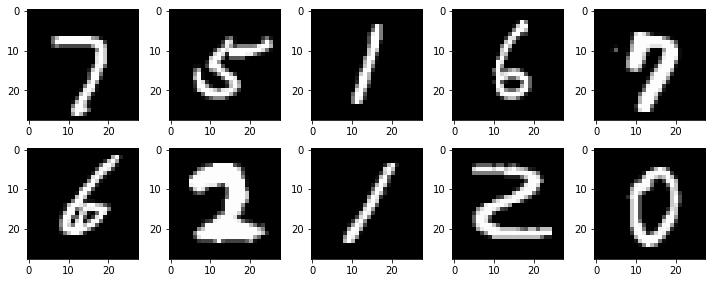

Batch x Width x Height: [64, 28, 28]


In [3]:
%matplotlib inline

train_data = mnist_train.data.to(device)
test_data = mnist_test.data.to(device)

train_data = train_data / train_data.max()
test_data = test_data / test_data.max()

train_loader = DataLoader(list(train_data), batch_size=64, shuffle=True)
test_loader = DataLoader(list(test_data), batch_size=64, shuffle=False)

first_batch = next(iter(train_loader))
sample_images = first_batch[:10].cpu().numpy()

fig, axes = plt.subplots(2, 5, figsize=(2*5, 2*2))
for i in range(10):
    ax = axes[divmod(i,5)]
    ax.imshow(sample_images[i], cmap='gray')
plt.tight_layout()
plt.show()

num_batches = len(train_loader)
print(f'Batch x Width x Height: {list(first_batch.shape)}')

### Model Definition

In [16]:
class LinBlock(torch.nn.Module):
            def __init__(self, in_features, out_features, p=0):
                super().__init__()

                self.res = nn.Linear(in_features, out_features) 
                self.lin = nn.Sequential(
                    nn.Linear(in_features, out_features),
                    nn.ReLU(),
                )

                self.dropout = nn.Dropout(p) 

            def forward(self, x):
                x_res = self.res(x)
                x = self.lin(x) + x_res
                x = F.layer_norm(x, tuple(x.shape[1:]))
                return self.dropout(x)

class VAE_Dense(nn.Module):

    def __init__(self, latent_size) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=-1),
            LinBlock(28*28, 512, p=0.2),
            nn.Linear(512, 2*latent_size)
        )

        self.decoder = nn.Sequential(
            LinBlock(latent_size, 512, p=0.2),
            LinBlock(512, 28*28, p=0.2),
            nn.Linear(28*28, 2*28*28),
        )

    def forward(self, x, n_z=1):
        mu_z, logvar_z = self.encoder(x).chunk(2, dim=-1)
        
        std_z = torch.exp(0.5 * logvar_z)

        latent_samples = []
        kld = 0
        # draw N samples from latent space
        for i in range(n_z):
            eps = torch.randn_like(std_z)
            z = std_z * eps + mu_z
            
            latent_samples.append(self.decoder(z))
            # sum over latent dim, average over batch
            kld += torch.mean(-0.5 * torch.sum(1 + logvar_z - (mu_z ** 2) - logvar_z.exp(), dim=1)) 
        kld /= i+1
        mu_x, logvar_x = torch.stack(latent_samples, dim=1).view(-1, n_z, 2, 28, 28).chunk(2, dim=2)

        return mu_x.squeeze(2).mean(1), logvar_x.squeeze(2).mean(1), kld

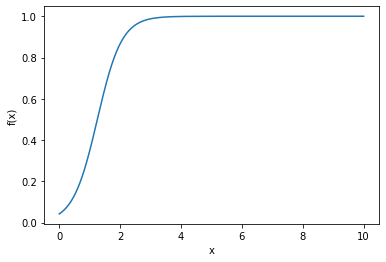

In [20]:
import matplotlib.pyplot as plt

latent = 4
epochs = 100

# model = VAE_Conv(latent_size=latent)
model = VAE_Dense(latent_size=latent).to(device)
optimizer = torch.optim.Adam(model.parameters(), 0.001)

x_ticks = torch.linspace(0, 10, num_batches * epochs)
kl_weights = 1/(1 + torch.exp(-2.5*(x_ticks-1.25))).detach()
  
plt.plot(x_ticks, kl_weights)
plt.xlabel("x")
plt.ylabel("f(x)")
  
plt.show()

## Training

In [21]:
model.train()

loss_history = []
kld_history = []
step = 0
for _ in tqdm(range(epochs)):
    train_mse = 0
    train_logl = 0
    avg_kld = 0
    for i, image_batch in enumerate(train_loader):
        optimizer.zero_grad()

        mu_x, logvar_x, kld = model(image_batch, n_z=1)

        log_likelihood = -((image_batch - mu_x) ** 2) / (2 * torch.exp(logvar_x)) - logvar_x - math.log(math.sqrt(2 * math.pi))
        log_likelihood = log_likelihood.sum((1,2)).mean()

        kld_weight = kl_weights[step]
        loss = kld_weight * kld - log_likelihood

        std_z = torch.exp(0.5 * logvar_x)
        train_mse += torch.mean(((mu_x + std_z) - image_batch)**2).item()
        avg_kld += kld.item()
        train_logl -= log_likelihood.item()
                
        loss.backward()
        optimizer.step()
        step += 1

    train_mse /= i+1
    train_logl /= i+1
    avg_kld /= i+1

    kld_history.append(avg_kld)
    loss_history.append(train_mse)

print("Train MSE: {:.4f}".format(train_mse))

torch.save(model.state_dict(), 'model_gaussian.pt')

100%|██████████| 100/100 [09:33<00:00,  5.74s/it]

Train MSE: 0.0817


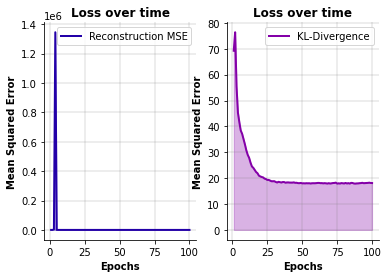

In [22]:
### RESULTS PLOT
colors = ['#2300a8', '#8400a8'] # '#8400a8', '#00A658'
plot_dict = {'Reconstruction MSE': (loss_history, colors[0]), 'KL-Divergence': (kld_history, colors[1])}
# plot_dict = {'Reconstruction': (loss_history, colors[0])}

n = len(loss_history)

# plot train and val losses and log_likelihood area under the curve
fig, axes = plt.subplots(1,2)
x_axis = list(range(1, n+1))
for i, (key, (data, color)) in enumerate(plot_dict.items()):
    ax = axes[i]
    ax.plot(x_axis, data, 
                label=key, 
                linewidth=2, 
                linestyle='-', 
                alpha=1, 
                color=color)
    ax.fill_between(x_axis, data, 
                alpha=0.3, 
                color=color)
    
    # figure labels
    ax.set_title('Loss over time', fontweight='bold')
    ax.set_xlabel('Epochs', fontweight='bold')
    ax.set_ylabel('Mean Squared Error', fontweight='bold')
    ax.legend(loc='upper right')

    # remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # adds major gridlines
    ax.grid(color='grey', linestyle='-', linewidth=0.35, alpha=0.8)

# y-axis in log scale (reconstruction loss tends to start high)
# ax.set_yscale('log')
plt.show()

## Testing

In [23]:
### TEST 
model.load_state_dict(torch.load('model_gaussian.pt'))
model.eval()
test_mse = 0
reconstructions = []
with torch.no_grad():
    h, c = None, None
    for i, image_batchx in enumerate(test_loader):
        n_z = 50
        mu_x, logvar_x, kld = model(image_batch, n_z)

        log_likelihood = -((image_batch - mu_x) ** 2) / (2 * torch.exp(logvar_x)) - logvar_x - math.log(math.sqrt(2 * math.pi))
        log_likelihood = log_likelihood.sum((1,2)).mean()

        std_x = torch.exp(0.5 * logvar_x)
        rec = (mu_x + std_x)

        test_mse += torch.mean((rec - image_batch)**2).item()
        reconstructions.append((image_batch, rec))

    test_mse /= i+1

print("Test MSE: {:.4f}".format(test_mse))

Test MSE: 0.0735


### Plots

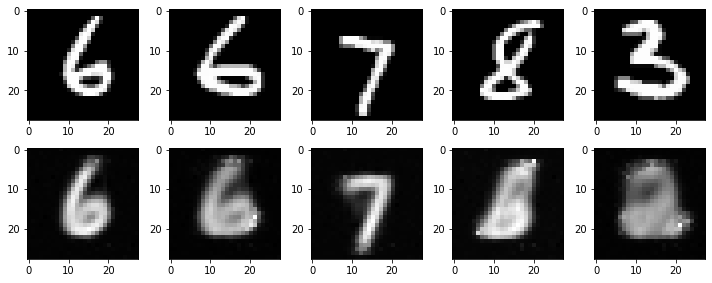

In [24]:
input, reconstructed = reconstructions[0][:5]

fig, axes = plt.subplots(2, 5, figsize=(2*5, 2*2))
for i in range(5):
    ax = axes[0,i]
    ax.imshow(input[i].cpu().numpy(), cmap='gray')
    ax = axes[1,i]
    ax.imshow(reconstructed[i].cpu().numpy(), cmap='gray')
plt.tight_layout()
plt.show()